In [1]:
from google.colab import drive
drive.mount("/content/drive")

PROJECT_ROOT = "/content/drive/MyDrive/stress-heart-ml-wesad"


Mounted at /content/drive


In [2]:
import os

PROJECT_ROOT = "/content/stress-heart-ml-wesad"
DATA_DIR = f"{PROJECT_ROOT}/data/processed"
RESULTS_DIR = f"{PROJECT_ROOT}/results"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Project directories ready ✅")


Project directories ready ✅


In [3]:
import kagglehub

path = kagglehub.dataset_download("mohamedasem318/wesad-full-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.43G/2.43G [01:23<00:00, 31.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mohamedasem318/wesad-full-dataset/versions/2


In [4]:
import os

root = "/root/.cache/kagglehub/datasets"

for path, dirs, files in os.walk(root):
    print(path)
    break

/root/.cache/kagglehub/datasets


In [5]:
for path, dirs, files in os.walk(root):
    if any(f.endswith(".pkl") for f in files):
        print("FOUND:", path)
        print("FILES:", files)
        break

FOUND: /root/.cache/kagglehub/datasets/mohamedasem318/wesad-full-dataset/versions/2/WESAD/S13
FILES: ['S13_readme.txt', 'S13.pkl', 'S13_quest.csv', 'S13_respiban.txt']


In [6]:
import pickle

base = "/root/.cache/kagglehub/datasets/mohamedasem318/wesad-full-dataset/versions/2/WESAD/S13"

path = os.path.join(base, "S13.pkl")

with open(path, "rb") as f:
    data = pickle.load(f, encoding="latin1")

data.keys()


dict_keys(['signal', 'label', 'subject'])

In [7]:
signals = data['signal']['wrist']

eda = signals['EDA']

print("EDA Shape:", eda.shape)


EDA Shape: (22148, 1)


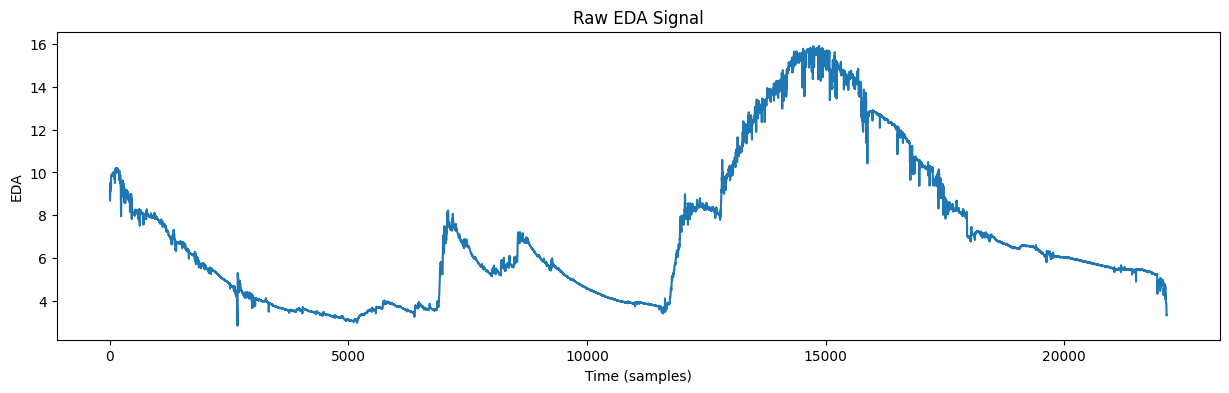

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.plot(eda)
plt.title("Raw EDA Signal")
plt.xlabel("Time (samples)")
plt.ylabel("EDA")
plt.show()


Prepared EDA shape: (22148,) dtype: float64


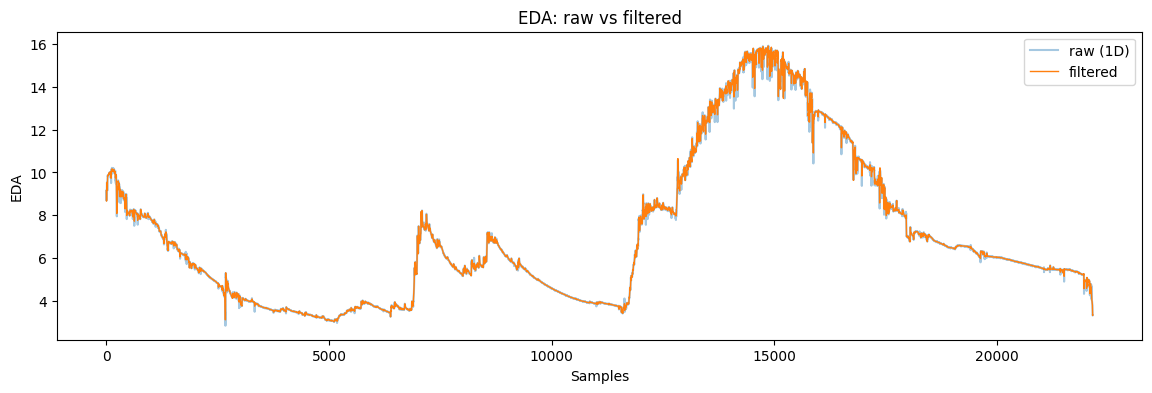

In [9]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

eda_raw = eda

# Convert to 1D
eda_1d = np.asarray(eda_raw).squeeze()

if eda_1d.ndim == 0:
    eda_1d = np.atleast_1d(eda_1d)

mask_bad = ~np.isfinite(eda_1d)
if mask_bad.any():
    idx = np.arange(eda_1d.size)
    good = ~mask_bad
    if good.sum() < 2:
        raise ValueError("Too many NaNs/infs in EDA to interpolate.")
    eda_1d = np.interp(idx, idx[good], eda_1d[good])

eda_1d = eda_1d.astype('float64')

print("Prepared EDA shape:", eda_1d.shape, "dtype:", eda_1d.dtype)
def butter_lowpass_filter_safe(x, cutoff=0.5, fs=4, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    padlen = 3 * max(len(a), len(b))
    if len(x) <= padlen:
        win = min(5, max(1, len(x)//5))
        return np.convolve(x, np.ones(win)/win, mode='same')

    try:
        y = filtfilt(b, a, x)
        return y
    except Exception as e:
        print("filtfilt failed, falling back to moving average. Error:", str(e))
        win = min(5, max(1, len(x)//5))
        return np.convolve(x, np.ones(win)/win, mode='same')
eda_filtered = butter_lowpass_filter_safe(eda_1d, cutoff=0.5, fs=4, order=4)
plt.figure(figsize=(14,4))
plt.plot(eda_1d, alpha=0.4, label='raw (1D)')
plt.plot(eda_filtered, linewidth=1, label='filtered')
plt.legend()
plt.title("EDA: raw vs filtered")
plt.xlabel("Samples")
plt.ylabel("EDA")
plt.show()


Prepared EDA shape: (22148,) dtype: float64


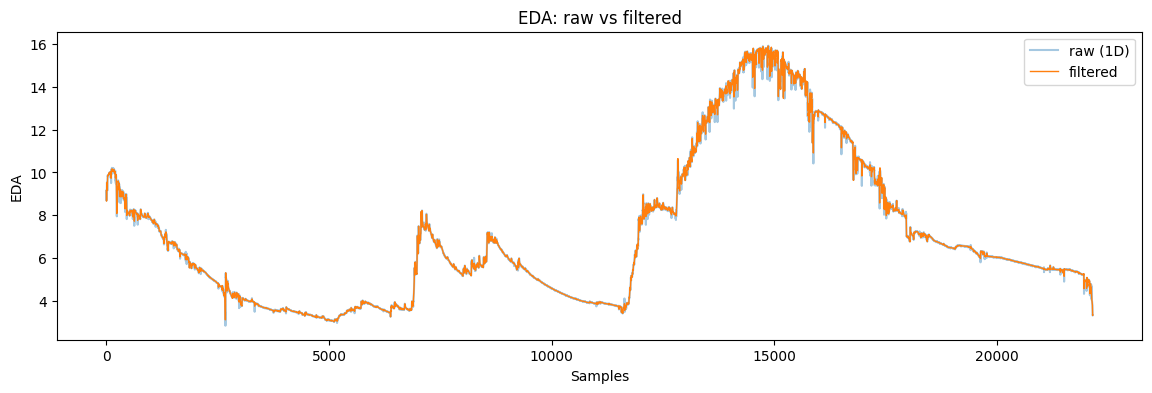

In [10]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

eda_raw = eda

# Convert to 1D
eda_1d = np.asarray(eda_raw).squeeze()

if eda_1d.ndim == 0:
    eda_1d = np.atleast_1d(eda_1d)

mask_bad = ~np.isfinite(eda_1d)
if mask_bad.any():
    idx = np.arange(eda_1d.size)
    good = ~mask_bad
    if good.sum() < 2:
        raise ValueError("Too many NaNs/infs in EDA to interpolate.")
    eda_1d = np.interp(idx, idx[good], eda_1d[good])

eda_1d = eda_1d.astype('float64')

print("Prepared EDA shape:", eda_1d.shape, "dtype:", eda_1d.dtype)
def butter_lowpass_filter_safe(x, cutoff=0.5, fs=4, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    padlen = 3 * max(len(a), len(b))
    if len(x) <= padlen:
        win = min(5, max(1, len(x)//5))
        return np.convolve(x, np.ones(win)/win, mode='same')

    try:
        y = filtfilt(b, a, x)
        return y
    except Exception as e:
        print("filtfilt failed, falling back to moving average. Error:", str(e))
        win = min(5, max(1, len(x)//5))
        return np.convolve(x, np.ones(win)/win, mode='same')
eda_filtered = butter_lowpass_filter_safe(eda_1d, cutoff=0.5, fs=4, order=4)
plt.figure(figsize=(14,4))
plt.plot(eda_1d, alpha=0.4, label='raw (1D)')
plt.plot(eda_filtered, linewidth=1, label='filtered')
plt.legend()
plt.title("EDA: raw vs filtered")
plt.xlabel("Samples")
plt.ylabel("EDA")
plt.show()


In [12]:
from scipy.signal import find_peaks
import numpy as np

# EDA should be filtered first -> using eda_filtered
# normalize for easier peak detection
eda_norm = (eda_filtered - eda_filtered.min()) / (eda_filtered.max() - eda_filtered.min())

# detect peaks: height and distance prevent false spikes
peaks, properties = find_peaks(eda_norm, height=0.1, distance=10)

print("Number of SCR Peaks:", len(peaks))

Number of SCR Peaks: 854


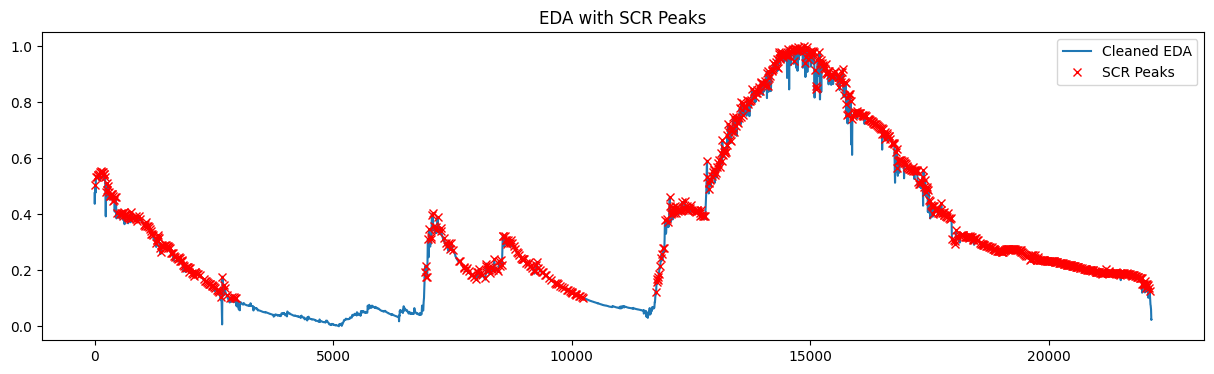

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.plot(eda_norm, label="Cleaned EDA")
plt.plot(peaks, eda_norm[peaks], "rx", label="SCR Peaks")
plt.title("EDA with SCR Peaks")
plt.legend()
plt.show()

In [14]:
import numpy as np

np.save(f"{DATA_DIR}/eda_filtered.npy", eda_filtered)
print("✅ Saved cleaned EDA")


✅ Saved cleaned EDA
